In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

#import tensorflow_decision_forests as tfdf

#from tensorflow import tensorflow_decision_forests

2.12.1


In [3]:
raw_dataset = pd.read_csv('~/Documents/Classes/STAT5610data/SierraBighornExampleSmall.csv')

In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset.head()

,y,asp,elev,slope,MOD.big
0,100,328.0,1931.0,14.0,62
1,89,243.0,2525.0,1.0,100
2,59,86.0,2442.0,4.0,38
3,100,32.0,2673.0,16.0,99
4,100,324.0,2807.0,6.0,93


In [6]:
dataset.tail()

,y,asp,elev,slope,MOD.big
19995,79,120.0,2458.0,29.0,86
19996,70,48.0,2442.0,13.0,73
19997,87,331.0,3058.0,16.0,93
19998,100,129.0,2503.0,7.0,95
19999,78,78.0,2533.0,6.0,92


In [7]:
dataset.isna().sum()

y          0
asp        0
elev       0
slope      0
MOD.big    0
dtype: int64

In [8]:
train_dataset = dataset.sample(frac=0.6, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,12000.0,79.346583,24.530150,0.0,66.0,86.0,100.00,100.0
asp,12000.0,175.067321,104.204583,-1.0,84.0,175.0,264.25,360.0
elev,12000.0,2681.027840,475.406446,1160.0,2326.0,2626.0,3058.00,3910.0
slope,12000.0,15.628657,12.211061,0.0,6.0,13.0,23.00,71.0
MOD.big,12000.0,83.038167,23.321332,0.0,81.0,91.0,97.00,100.0


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_y = train_features.pop("y")
test_y = test_features.pop("y")

train_features.describe()

,asp,elev,slope,MOD.big
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,175.067321,2681.027840,15.628657,83.038167
std,104.204583,475.406446,12.211061,23.321332
min,-1.000000,1160.000000,0.000000,0.000000
25%,84.000000,2326.000000,6.000000,81.000000
50%,175.000000,2626.000000,13.000000,91.000000
75%,264.250000,3058.000000,23.000000,97.000000
max,360.000000,3910.000000,71.000000,100.000000


In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1) # each item in the last axis

In [12]:
normalizer.adapt(np.array(train_features))

2023-11-16 09:36:58.809800: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
print(normalizer.mean.numpy())

[[ 175.067 2681.03    15.629   83.038]]


In [14]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 180. 2136.    1.    0.]]

Normalized: [[ 0.05 -1.15 -1.2  -3.56]]


In [15]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [16]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 102ms/step


array([[ 1.317],
       [-0.127],
       [ 0.762],
       [ 0.027],
       [ 1.164],
       [ 1.327],
       [ 0.181],
       [-0.577],
       [-0.183],
       [-0.504]], dtype=float32)

In [17]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.737],
       [ 0.472],
       [-0.397],
       [-0.378]], dtype=float32)>

In [18]:
linear_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [19]:
%%time
history = linear_model.fit(
    train_features,
    train_y,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 10.1 s, sys: 1.5 s, total: 11.6 s
Wall time: 7.89 s


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [landsat]')
  plt.legend()
  plt.grid(True)

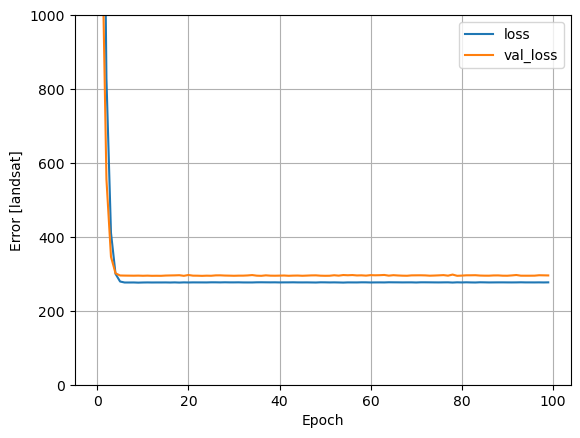

In [21]:
plot_loss(history)

In [22]:
test_results = {}

test_results['mlr_model'] = linear_model.evaluate(
    test_features, test_y, verbose=0)

In [23]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.legacy.Adam(0.001))
  return model

In [24]:
dnn_model = build_and_compile_model(normalizer)

In [25]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [27]:
%%time
history = dnn_model.fit(
    train_features,
    train_y,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.9 s, sys: 2.6 s, total: 15.5 s
Wall time: 9.84 s


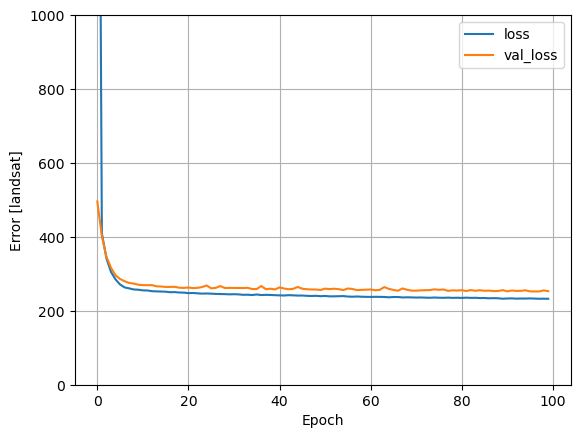

In [28]:
plot_loss(history)

In [29]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_y, verbose=0)

In [30]:
print(test_results)

{'mlr_model': 284.3698425292969, 'dnn_model': 239.2939910888672}


In [ ]:
#import tensorflow_decision_forests as tfdf

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
rf = RandomForestRegressor(n_estimators=200,random_state=1)

In [34]:
rf.fit(train_features,train_y)

RandomForestRegressor(n_estimators=200, random_state=1)

In [35]:
rf_pred = rf.predict(test_features)

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
mean_squared_error(rf_pred,test_y)

232.86678034257713